In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from timeit import default_timer as timer
import statistics

In [8]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/Problem_solving

Mounted at /content/drive
/content/drive/MyDrive/Problem_solving


In [2]:
N_Avog   = 6.022e23    # Avogadro number
e_charge = 1.60e-19    # electron charge (C)
e_radius = 2.82e-13    # classical electron radius (cm)
e_mass   = 0.511*10**(-3)         # electron mass (GeV)
Z_tar    = 10.         # water atomic number
A_tar    = 18.         # water mass number
c        = 3.e10       # speed of light (cm/s)
J        = 1.6e-10     # conversion from GeV to J
rho      = 1.          # water density (g/cm3)
I_pot    = 78./1.e9    # Ionization potential of water = 78 eV converted in GeV



### Define the radius of the sphere ###
radius =    15                         # cm   (the sphere is centered in the origin)
###
S      = 4*math.pi*radius**2         # cell surface in cm^2
V      = 4./3.*math.pi*radius**3     # volume

# Parameters of the cosmic rays
### Define the flux of cosmic rays ###
flux =       4e5     # ions/(cm^2*day)
###

Definisco la funzione Bethe-Bloch

In [3]:
def bethe(Ekin, rho, Z_tar, A_tar, I_pot):
  if Ekin > 0.1:
    gamma    = 1 + Ekin/m_proj            # relativistic gamma
    beta     = math.sqrt(1-1/gamma**2)    # beta = v/c as a function of kinetic energy
    const    = 4.*math.pi*N_Avog*e_radius**2*e_mass*rho*Z_tar/A_tar*z_proj**2       # constant term in bethe-bloch
    factor   = (1./beta**2)*(math.log(2*e_mass*gamma**2*beta**2/I_pot)-beta**2)     # energy-dependent term (I_pot converted from eV to MeV)
    dEdx     = const*factor    # stopping power = bethe-bloch = dE/dx
    if dEdx*dx > Ekin:
      dEdx = Ekin/dx
    dE = dEdx*dx
  else:
    dE = Ekin
    dEdx = dE/dx
#  E_dep    = E_dep + dE      # Total deposited energy
  Ekin        = Ekin - dE
  return dE, Ekin

In [4]:
### Parametri di input per la funzione bethe ###

#Silicio
rho_Si= 2.33       #densità del target g/cm^3
Z_tar_Si=  14    #Z del target
A_tar_Si=   28   #A target
I_pot_Si=  8.15*10**(-9)    #Ionization potential of water in GeV

#Alluminio#
rho_Al= 2.70       #densità del target g/cm^3
Z_tar_Al=  13    #Z del target
A_tar_Al=   26   #A target
I_pot_Al=  5.98*10**(-9)    #Ionization potential of water in GeV

In [5]:
##Funzioni per Monte Carlo

def f1(x):  
  if x>=0 and x<=2:
    f1 = 1800
  else:
    f1=1800/(x-1)
  return f1  

def cumulativa(x):
  if x>0 and x<=2:
    F=1800*x
  else:
    F=1800*(2+np.log(x-1))  
  return F   

def inversa(y):
  if y>0 and y<=3600:
    Inv=y/1800
  else:
    Inv=np.exp(y/1800-2)+1
  return Inv 

def f_He(x):  
  if x>0 and x<=0.3:
    f1 = 250
  else:
    f1 = 250*np.exp(0.3)*np.exp(-x)
  return f1  

def cumulativa_He(x):
  if x>0 and x<0.3:
    F=250*x
  else:
    F = 250*(-np.exp(0.3-x)+1.3)
  return F 

def inversa_He(y):
  if y>0 and y<=75:
    Inv=y/250
  else:
    Inv = -np.log(np.exp(-0.3)*(-y/250+1.3))
  return Inv 

def f_b(x):  
  if x>0.4 and x<=2:
    f1 = 2
  elif x>2:
    f1 = 2**4*x**(-3)
  else:
    return 0
  return f1  

def cumulativa_B(x):
  if x>0.4 and x<=2:
    F=2*x
  elif x>2:
    F=4*(3-2/x**2)
  else:
    return 0
  return F 

def inversa_B(y):
  if y>0.8 and y<=4:
    Inv=y/2
  elif y>4:
    Inv=np.sqrt(8/(12-y))
  else:
    return 0
  return Inv 

F_50=cumulativa(10**5)
F_1=cumulativa_He(10**5)
F_B=cumulativa_B(10**5)

In [6]:
#funzione di fit 

def model1(x, gamma, b, a, A, PHI, Er):
  p=A*(x+a*np.exp(-b*x)+PHI)**(-gamma)*x*(x+2*Er)/((x+PHI)*(x+2*Er+PHI))
  return p


Simulazione per calcolo **dose**

In [9]:
strato_Si = 3.    #spessore strato di silicio in cm
strato_Al = 3.   #spessore strato di alluminio in cm

N_runs = 10**6         # Number of simulations, to obtain the correct statistics
count=0 #Numero di particelle accettate              
    
random.seed(15)
E_dep = 0.
E_dep_Si = 0.
E_dep_Al= 0.

E_errore=np.array([])   # Array per salvare le energie depositate per ogni nucleone
  
for n in range(N_runs): 
  E_dep_Si_i= 0.
  E_dep_Al_i= 0.
  E_dep_sfera_i=0.
    
  phi1   = random.random()*2*math.pi
  theta1 = math.acos(1 - 2*random.random())

  x1    = radius*math.sin(theta1)*math.cos(phi1)          # cartesian coordinates of the origin of the ion (on the sphere surface)
  y1    = radius*math.sin(theta1)*math.sin(phi1)
  z1    = radius*math.cos(theta1)

  phi2   = 2*math.pi*random.random()          # phi is uniform between 0 and 2pi
  theta2 = math.acos(1 - 2*random.random())

  r = -(2*x1*math.sin(theta2)*math.cos(phi2)+2*y1*math.sin(theta2)*math.sin(phi2)+2*z1*math.cos(theta2))

  if r > 0.:
    ion_rand = random.random()

    if ion_rand < 0.87:
       ion_type = 1                                  # Protone
       m_proj   = 0.938
       z_proj   = 1
       psi1=random.random()
       psi2=psi1*F_50
       x1=inversa(psi2)
       p=model1(x1,2.6680, 0.0001, 0.2531, 13578.0045, 0.7, m_proj)
       psi3=random.random()
       y=psi3*f1(x1)
       if y<=p:
         E=x1
       else:
         E=0
       
    elif ion_rand >=0.87 and ion_rand < 0.99:
       ion_type = 2                                  # Ione elio
       m_proj   = 0.938*4.
       z_proj   = 2
       
       psi1=random.random()
       psi2=psi1*F_1
       x2=inversa_He(psi2)
       p_He = model1(x2, 2.8813, 1.6268, 1.76533*10**(-13), 849.3254, 0.7, m_proj)
       psi3=random.random()
       y=psi3*f_He(x2)
       if y<=p_He:
         E=x2
       else:
         E=0


    else:
       ion_type = 3                                  # Boro
       m_proj   = 0.938*10.
       z_proj   = 5
       psi1=random.random()
       psi2=psi1*F_B
       if psi2 > 0.4:
         x2=inversa_B(psi2)
         p_B = model1(x2, 2.9306, 0.2687, 0.5909, 6.1646, 0.3, m_proj)
         psi3=random.random()
         y=psi3*f_b(x2)
         if y<=p_B:
           E=x2
         else:
           E=0
         
      
         
    if E>0:
      count=count+1
      x     = 0.
      dx    = 0.01

      while x <= strato_Si:
         x = x + dx
         dE, E = bethe(E, rho_Si, Z_tar_Si, A_tar_Si, I_pot_Si)  #Si
         E_dep_Si = E_dep_Si + dE  
         E_dep_Si_i = E_dep_Si_i + dE
        
      x     = 0.
      dx    = 0.01
    
      E_1 = max(E-E_dep_Si_i,0)
      while x <= strato_Al:          #nello strato protettivo alluminio

          x = x + dx
          dE, E_1 = bethe(E_1, rho_Al, Z_tar_Al, A_tar_Al, I_pot_Al)  #Si
          E_dep_Al = E_dep_Al + dE    
          E_dep_Al_i = E_dep_Al_i + dE
      
      x     = 0.                #nella sfera d'acqua (astronauta)
      dx    = 0.01
      
      E_2 = max(E_1-E_dep_Al_i,0)      #do in input energie attenuate dallo schermo
      while x <= r:
          x = x + dx
          dE, E_2 = bethe(E_2, rho, Z_tar, A_tar, I_pot )
          E_dep = E_dep + dE
          E_dep_sfera_i=E_dep_sfera_i+dE
      E_errore=np.append(E_errore,E_dep_sfera_i)
    else:
      pass
 
Energia_dep = E_dep/count #GeV
Errore_energia = np.std(E_errore)/np.sqrt(count) #GeV

Dose=(E_dep*flux*S*J*700/((V*rho*1.e-3)*count)) #Gy
efficienza=count*100/N_runs
print('Energia depositata per nucleone in GeV =', Energia_dep)
print('Errore sulla media energia depositata in GeV =', Errore_energia)
print('Dose per 700 giorni in Gray =', Dose)
print('Punti accettati =', count)
print('Punti accettati su punti totali in % =', efficienza)

Energia depositata per nucleone in GeV = 0.06658430479020072
Errore sulla media energia depositata in GeV = 0.00037549873977293295
Dose per 700 giorni in Gray = 0.5965953709201984
Punti accettati = 106178
Punti accettati su punti totali in % = 10.6178


In [10]:
Errore_relativo=Errore_energia/(Energia_dep)
Errore_dose=Errore_relativo*Dose
print('Dose media in Gy =', Dose)
print('Errore sulla dose =', Errore_dose)

Dose media in Gy = 0.5965953709201984
Errore sulla dose = 0.003364468708365479


In [11]:
E_dep_nonzero=E_errore[E_errore != 0]

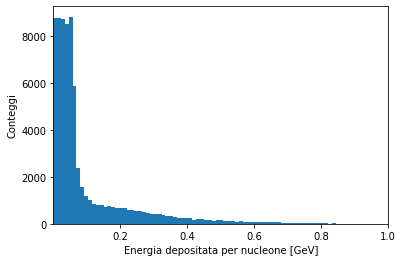

In [12]:
_=plt.hist(E_dep_nonzero, bins=300)
#plt.ylim([0,10000])
plt.xlim([0.0001,1])
plt.xlabel('Energia depositata per nucleone [GeV]')
plt.ylabel('Conteggi')
plt.savefig('istogramma.pdf')
plt.show()

In [13]:
#Quante volte l'energia depositata nell'astronauta è zero 
Non_zero=np.count_nonzero(E_errore)
Size=np.size(E_errore)
Zero_values=Size-Non_zero
print(Zero_values)

33969
